<a href="https://colab.research.google.com/github/SeongSihun/XRD-Analysis/blob/main/CTR_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Six Circle Orientation (Settings)
- made by SeongSihun

- 런타임 / 모두실행  [ ⌘/ctrl + F9 ]

---
## IMPORT

In [ ]:
%reset -f
import numpy as np
from scipy.constants import h, c, e, pi
from scipy.linalg import inv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

---
## LIB

### TOOLs

#### python <=> matlab

In [ ]:
sind  = lambda deg: 0 if deg % 180 == 0 else np.sin(np.radians(deg))
cosd  = lambda deg: 0 if (deg+90) % 180 == 0 else np.cos(np.radians(deg))
tand  = lambda deg: 0 if (deg) % 180 == 0 else np.tan(np.radians(deg))
#
asind = lambda val: np.degrees(np.arcsin(val))
acosd = lambda val: np.degrees(np.arccos(val))
atan2d= lambda y,x: np.degrees(np.arctan2(y, x))
#
norm  = lambda vec: np.linalg.norm(vec)
inv   = lambda mat: np.linalg.inv(mat)

#### Angle between couple of vectors

In [ ]:
# find angle between two vectors
def anglebet(v1, v2):
    Y = v1 @ v2 / (norm(v1) * norm(v2))
    Y = Y/np.abs(Y) if (np.abs(Y) > 1) and (np.abs(Y) < 1+1e-10) else Y
    return acosd(Y)

    # with sign obtained based on ref. vector
def signanglebet(v1, v2, ref):
    rot = np.cross(v1, v2)
    sign = 1 if (x:= ref @ rot) == 0 else x / norm(x)
    return (sign * anglebet(v1, v2))

#### pandas, empty frame

In [ ]:
emptyFrame = lambda : pd.DataFrame(columns=['phi', 'chi', 'eta', 'mu', 'delta', 'gamma', 'theta', 'qaz', 'alpha', 'naz', 'tau', 'psi'])

### Functions

#### Frames

In [ ]:
def hkl2xyz(hkl, Z, scale):
    return Z @ hkl * scale

def xyz2hkl(xyz, Z, scale):
    return inv(Z) @ xyz / scale

#### hkl2theta
- |Q| = 2ksin($\theta$)

In [ ]:
def hkl2theta(hkl, scale):
    return asind(norm(hkl * scale) / 2)

#### xyz to Horizon Coordinate
- xyz  to theta, qaz
- nxyz to alpha, naz

In [ ]:
def xyz2horizon(xyz):
    altitude = 90 - anglebet(xyz, np.array([0, -1, 0]).T)
    azimuth  = atan2d(xyz[0], xyz[2])
    return (altitude, azimuth)

#### sigtau
- nxyz to sigtau

In [ ]:
def xyz2sigtau(nxyz):
    sigma = anglebet(nxyz, np.array([0,0,1]))
    tau_naz = atan2d(-nxyz[1], nxyz[0])
    return (sigma, tau_naz)

#### Sample frame(Qmu xyz) to Detector angles(delta, gamma)
- Qmu = hkl2xyz(hkl, I, [energy, abc])

In [ ]:
def Qmu2det(Qmu, mu):
    delta = atan2d(Qmu[0], Qmu[1]+cosd(mu))
    gamma = asind(Qmu[2]-sind(mu))
    return (delta, gamma)

#### angle(phi, chi, eta, mu) to Z

In [ ]:
def angle2Z(phi, chi, eta, mu):
    PHI = np.array([
    [cosd(phi), sind(phi), 0],
    [-sind(phi), cosd(phi), 0],
    [0, 0, 1]
    ])
    CHI = np.array([
        [cosd(chi), 0, sind(chi)],
        [0, 1, 0],
        [-sind(chi), 0, cosd(chi)]
    ])
    ETA = np.array([
        [cosd(eta), sind(eta), 0],
        [-sind(eta), cosd(eta), 0],
        [0, 0, 1]
    ])
    MU = np.array([
        [1, 0, 0],
        [0, cosd(mu), -sind(mu)],
        [0, sind(mu), cosd(mu)]
    ])
    Z = MU @ ETA @ CHI @ PHI
    return Z

In [ ]:
def det2Z(mu, delta, gamma):
    MU = np.array([
        [1, 0, 0],
        [0, cosd(mu), -sind(mu)],
        [0, sind(mu), cosd(mu)]
    ])
    DELTA = np.array([
        [cosd(delta), sind(delta), 0],
        [-sind(delta), cosd(delta), 0],
        [0, 0, 1]
    ])
    GAMMA = np.array([
        [1, 0, 0],
        [0, cosd(gamma), -sind(gamma)],
        [0, sind(gamma), cosd(gamma)]
    ])
    return MU @ DELTA @ GAMMA

#### xyz2intersection
- Ewardsphere와의 교점 구하는 함수

In [ ]:
def xyz2intersection(Qmu):
    # Qmu == (0, 0, 0), rho 해가 없다.
    if norm(Qmu) == 0: return np.array([])
    #
    rho = 90 - anglebet(np.array([1,0,0]), Qmu)
    if norm(Qmu) <= 2 * cosd(rho)  :
        x0, y0, z0 = Qmu
        R = np.sqrt(y0**2 + z0**2)
        # r = np.sqrt(1-x0**2)
        # y = 0.5 * (r**2 - R**2 - 1)
        y = -0.5 * norm(Qmu)**2
        z = np.sqrt(R**2 - y**2)
        if z == 0 : # 중근
            return [x0, y, z]
        else : return np.array([[x0, y, z], [x0, y, -z]])
    else: return np.array([])

#### alpha 찾기 위한 na_at 구하기

In [ ]:
def alpha2na_at(nxyz_100, xyz_100, alpha):
    if alpha == 0:
        return [0]
    tau = anglebet(xyz_100, nxyz_100)
    #
    na_ats = []
    #
    A = sind(tau)
    B = cosd(tau)
    C = norm(xyz_100) / 2 / sind(alpha)

    na_at1 = acosd( (C-B)/np.sqrt(A**2 + (C-B)**2) )
    na_at2 = acosd( -(B+C)/np.sqrt(A**2 + (B+C)**2) )
    # print(na_at1, na_at2)
    if sind(tau+na_at1) > 0 : na_ats.append(na_at1)
    if sind(tau+na_at1) < 0 : na_ats.append(na_at2)
    return na_ats

#### sigtau의 반대, etachi

In [ ]:
def xyz2etachi(nxyz):
    eta = asind(-nxyz[1] / norm(nxyz))
    chi = atan2d(-nxyz[2], nxyz[0])
    return np.array([eta, chi])

### Modules

#### alongbymu

In [ ]:
def alongbymu(hkl, nhkl, init_angles, scale):
    angles = []
    index  = []

    phi, chi, eta, _ = init_angles
    init_angles[3] = 0

    # init location of Q xyz (Lab frame)
    Qmu = hkl2xyz(hkl, angle2Z(phi,chi,eta,0), scale)

    # intersection points
    intersections = xyz2intersection(Qmu)
    if intersections.size == 0:
        return emptyFrame()

    # QL
    for (xL, yL, zL) in intersections:
        #
        mu = signanglebet(Qmu * np.array([0,1,1]), np.array([0, yL, zL]), np.array([1,0,0]))

        # detector angles (Lab frame에서, mu 회전하기 전 [Qmu = init location of Q] 값을 이용.)
        delta, gamma = Qmu2det(Qmu, mu)

        # Lab frame 상에서의 Q (xyz) 계산
        Z  = angle2Z(phi, chi, eta, mu)
        xyz = hkl2xyz(hkl, Z, scale)

        # pseudo angles
        theta, qaz = xyz2horizon(xyz)

        # ref. pseudo angles
        nxyz = hkl2xyz(nhkl, Z, scale)
        alpha, naz = xyz2horizon(nxyz)
        #
        tau = anglebet(xyz, nxyz)
        Qref = 0.5 * xyz + np.array([0, 1, 0])
        nref = np.cross(np.cross(xyz, nxyz), xyz)
        psi = signanglebet(Qref, nref, xyz) if nref@nref!=0 else 0

        angles.append( [phi, chi, eta, mu, delta, gamma, theta, qaz, alpha, naz, tau, psi] )
        if index == []:
            index.append(f'{hkl[0]} {hkl[1]} {hkl[2]} +')
        else :
            index.append(f'{hkl[0]} {hkl[1]} {hkl[2]} -')

    # return np.array(angles)
    return pd.DataFrame(angles, columns=['phi', 'chi', 'eta', 'mu', 'delta', 'gamma', 'theta', 'qaz', 'alpha', 'naz', 'tau', 'psi'], index=index)

#### alpha_phi_fixed_scan

In [ ]:
def alpha_phi_fixed_scan(hkl, nhkl, alpha, phi, scale):
    if norm(hkl) == 0 or not anglebet(hkl, nhkl) :
        return [emptyFrame()]

    angles = [emptyFrame()]

    # find sigtau X now-> etachi

    nxyz0 = hkl2xyz(nhkl, angle2Z(phi, 0,0,0), scale)
    (chi0, eta0) = -xyz2etachi(nxyz0)[::-1]

    Z0 = angle2Z(phi,chi0,eta0,0)
    nxyz_100 = hkl2xyz(nhkl, Z0, scale)
    xyz_100  = hkl2xyz(hkl , Z0, scale)

    for na_at in alpha2na_at(nxyz_100, xyz_100, alpha):
        ratio = sind(na_at) / norm(xyz_100[1:3])
        nxyz_alpha_hat = np.array([cosd(na_at), *ratio*xyz_100[1:3]]) # tau==0일때 사용 불가.
        (chi, eta)  = np.array([chi0, eta0]) + xyz2etachi(nxyz_alpha_hat)[::-1]

        angle = alongbymu(hkl, nhkl, [phi,chi,eta,0], scale)
        if len([*angle['alpha']]) > 0 :
            angles.append(angle)

    return angles

---
# 6 Circle Orientation
- application

## initializing

In [ ]:
# # Sample : STO (001)
# abc = np.array([3.905, 3.905, 3.905]) * 1E-10
# nhkl= np.array([0, 0, 1])

# # Light : Cu kα1 => hc / lambda / e [eV]
# energy = 6.626E-34 * 299792458 / 1.5406e-10 / 1.602176565e-19

# #
# scale = [energy, abc]

# # phi, alpha
# (phi, alpha) = 0, 0

## L scan

In [ ]:
# angles1, angles2, L1, L2 = [], [], [], []
# (H, K) = (0, 5)

# for l in np.arange(0, 5, 0.01) :
#     # 부동소수점 오차
#     l = round(l, 10)
#     angle = pd.concat(
#         alpha_phi_fixed_scan(np.array([H, K, l]), nhkl, alpha, phi, [energy, abc])
#     )
#     if len(angle) > 0:
#         angles1.append(angle[0:1])
#         L1.append(l)
#     if len(angle) > 1:
#         angles2.append(angle[1:2])
#         L2.append(l)

# if not len(angles1) == 0 :
#     angles1 = pd.concat(angles1)

# if not len(angles2) == 0 :
#     angles2 = pd.concat(angles2)

# # angles1

In [ ]:
# plt.figure(figsize=(12, 6))

# plt.subplot(2, 3, 1)
# plt.title('phi'), plt.plot(L1, angles1['phi'], 'o', markersize=1), plt.plot(L2, angles2['phi'], 'o', markersize=1)
# plt.subplot(2, 3, 2)
# plt.title('chi'), plt.plot(L1, angles1['chi'], 'o', markersize=1), plt.plot(L2, angles2['chi'], 'o', markersize=1)
# plt.subplot(2, 3, 3)
# plt.title('eta'), plt.plot(L1, angles1['eta'], 'o', markersize=1), plt.plot(L2, angles2['eta'], 'o', markersize=1)
# plt.subplot(2, 3, 4)
# plt.title('mu'), plt.plot(L1, angles1['mu'], 'o', markersize=1), plt.plot(L2, angles2['mu'], 'o', markersize=1)
# plt.subplot(2, 3, 5)
# plt.title('delta'), plt.plot(L1, angles1['delta'], 'o', markersize=1), plt.plot(L2, angles2['delta'], 'o', markersize=1)
# plt.subplot(2, 3, 6)
# plt.title('gamma'), plt.plot(L1, angles1['gamma'], 'o', markersize=1), plt.plot(L2, angles2['gamma'], 'o', markersize=1)
# plt.suptitle(f'({H}{K}L) scan / alpha : {alpha}')

# # Save or show the plot
# # plt.savefig(f'./imgs/{alpha}/({H}{K}L)_scan.png')
# plt.show()
# print(len(L1), len(L2))

---
## Visualization

In [ ]:
# (phi, chi, eta, mu) = (0,-70,0,0)
# Q  =  np.array([2, -2, 1])

# #
# ax = plt.figure(figsize=(5,5)).add_subplot(projection='3d')
# ax.set_xlim(-1, 1), ax.set_ylim(-2, 1), ax.set_zlim(-1, 1)
# ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')

# ##
# # axis
# ax.quiver(0, 0, 0, 1, 0, 0, color='black')
# ax.quiver(0, 0, 0, 0, 1, 0, color='black')
# ax.quiver(0, 0, 0, 0, 0, 1, color='black')

# ##
# # 파라미터 설정
# center = (0, -1, 0)
# radius = 1
# cphi = np.linspace(0, np.pi, 100)
# ctheta = np.linspace(0, 2 * np.pi, 100)
# # 구의 표면 좌표 계산
# cphi, ctheta = np.meshgrid(cphi, ctheta)
# x = center[0] + radius * np.sin(cphi) * np.cos(ctheta)
# y = center[1] + radius * np.sin(cphi) * np.sin(ctheta)
# z = center[2] + radius * np.cos(cphi)
# # 구 표면 그리기
# ax.plot_surface(x, y, z, color='b', alpha=0.2)


# # Qmu
# Qmu = hkl2xyz(Q, angle2Z(phi,chi,eta,0), scale)
# ax.quiver(0, 0, 0, *Qmu, color='green', linewidth=3)
# #
# intersections = xyz2intersection(Qmu)
# if intersections.size != 0:
#     # QL
#     for (xL, yL, zL) in intersections:
#         #
#         mu = signanglebet(Qmu * np.array([0,1,1]), np.array([0, yL, zL]), np.array([1,0,0]))
#         print(f'mu : {mu}')
#         Z  = angle2Z(phi, chi, eta, mu)
#         xyz = hkl2xyz(Q, Z, scale)
#         ax.quiver(0, 0, 0, *xyz, color='red', linewidth=1)
#         #
#         delta, gamma = Qmu2det(Qmu, mu)
#         print(f'delta : {delta:.2f}, gamma : {gamma:.2f}')
#         # detector
#         ax.quiver(0, -1, 0, 0, 1, 0, color='blue', linewidth= .5)
#         ax.quiver(0, -1, 0, *(det2Z(mu, delta, gamma) @ np.array([0,1,0])),  color='blue', linewidth= .3)
#         # pseudo angles
#         theta, qaz = xyz2horizon(xyz)
#         print(f'theta : {theta:.2f}, qaz : {qaz:.2f}')
#         # ref. pseudo angles
#         nxyz = hkl2xyz(nhkl, Z, scale)
#         alpha, naz = xyz2horizon(nxyz)
#         print(f'alpha : {alpha:.2f}, naz : {naz:.2f}')
#         #
#         tau = anglebet(xyz, nxyz)
#         Qref = 0.5 * xyz + np.array([0, 1, 0])
#         nref = np.cross(np.cross(xyz, nxyz), xyz)
#         # print(Qref @ nref / norm(Qref) / norm(nref))
#         psi = signanglebet(Qref, nref, xyz) if nref@nref!=0 else 0
#         print(f'tau : {tau:.2f}, psi : {psi:.2f}')

#         # angles.append( [phi, chi, eta, mu, delta, gamma, theta, qaz, alpha, naz, tau, psi] )
#         print()

# ax.view_init(elev=120, azim=180)

---
#  ͏
#  ͏

---
# Experiment (Settings)
- test by uniform model
- only available to epitaxial samples

## STO : Scattering Settings

### Tools

In [ ]:
def cube3d(arr, dim=0b001):
    if dim == 0b100:
        return np.transpose(np.array(arr),(0, 2, 1))[:,:,::-1]
    elif dim == 0b010:
        return np.transpose(np.array(arr),(2, 0, 1))[::-1,:,::-1]
    elif dim == 0b001:
        return np.transpose(np.array(arr),(1, 2, 0))[:,:,::-1]
    else:
        print("err")
        return

def cuberange(X, Y, Z):
    for i in range(X):
        for j in range(Y):
            for k in range(Z):
                yield (i, j, k)

### Class

In [ ]:
class Sample():
  def __init__(self, structure, abc, NaNbNc, nhkl):
    self.structure = structure
    self.abc = abc
    self.NaNbNc = NaNbNc
    self.nhkl = nhkl

  # Pre-defined
  def perovskite(A=38, B=22, O=8): # default STO
    return cube3d(
            [[[A/8,   0, A/8], [  0, O/2,   0], [A/8,   0, A/8]],
             [[  0, O/2,   0], [O/2,   B, O/2], [  0, O/2,   0]],
             [[A/8,   0, A/8], [  0, O/2,   0], [A/8,   0, A/8]]], 0b100
          )

  def scaling(self, energy):
    fhc = h * c / e
    Kscale = 2 * pi * energy / fhc
    # Qscale
    Qscale = (2*pi/self.abc).T
    return Qscale / Kscale

  def pseudocubic(abc):
    a, b, c = abc
    ac      = np.sqrt(a**2 + b**2) / 2
    cc      = c / 2
    return (ac, ac, cc)

  def const_volume_abc(self, film_abc):
    a, b, _ = self.abc
    return (a, b, np.prod(film_abc) / (a*b))


### Modules

#### atomic form factor

In [ ]:
def aff(Z, hkl):
    if (G:=norm(hkl)) != 0:
        return Z / (G**2)
    else:
        return 0

#### Structure factor

In [ ]:
def Fc(hkl, STO):
  _STO = STO.structure
  (Nx, Ny, Nz) = len(_STO[:,0,0]),len(_STO[0,:,0]),len(_STO[0,0,:])
  fc = 0
  for (ii,jj,kk) in cuberange(Nx,Ny,Nz):
    if _STO[ii,jj,kk]==0 : continue
    rj = STO.abc * np.array([ii,jj,kk])/np.array([Nx-1, Ny-1, Nz-1])#-np.array([0.5,0.5,0.5])
    fc += aff(_STO[ii,jj,kk], hkl) * np.exp(2j * pi * hkl @ rj)
  return fc #np.real(fc)

#### Scattering Factor

In [ ]:
def Sz(Nz, L):
  # sum n is from -1 to -Nz of {exp(ixn)}  # ix = 2j * pi * L
  if np.isclose(1 - np.exp(-2j * pi * L), 0, atol=1e-10):
    return Nz
  else: return (   np.exp(-2j * pi * L) * ( 1 - np.exp(-2j * pi * L * Nz) ) / (1 - np.exp(-2j * pi * L))  )

def Sxy(Nz, L):
  # sum n is from 0 to (Nz-1) of {exp(ixn)}  # ix = 2j * pi * L
  if np.isclose(1-np.exp(2j * pi * L), 0, atol=1e-10):
    return Nz
  return (1-np.exp(2j * Nz * pi * L)) / (1-np.exp(2j * pi * L))

def E(hkl, bulk, surface):
  Sbulk = [Sxy, Sxy, Sz]
  # Ssurf = [Sxy, Sxy, Sxy]
  Ebulk = Fc(hkl, bulk)    * np.prod([Sbulk[i](bulk.NaNbNc[i], hkl[i]) for i in range(3)])
  Esurf = Fc(hkl, surface) * np.prod([Sxy(surface.NaNbNc[i], hkl[i]) for i in range(3)])
  return Ebulk + Esurf

def I(hkl, bulk, surface):
  return norm(E(hkl, bulk, surface)) ** 2

#### 1D Example

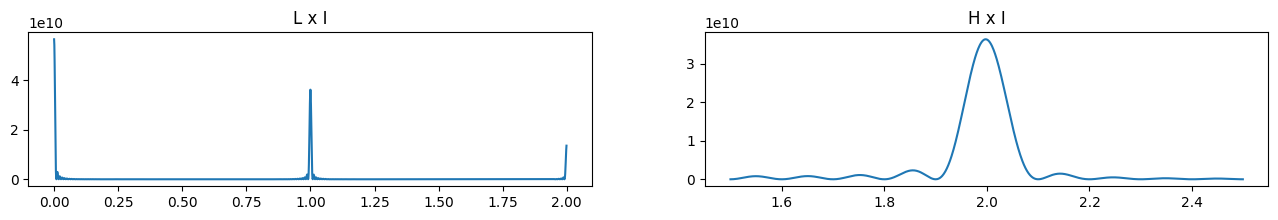

In [ ]:
Sr, Ti, O = (38, 22, 8)
Nd, Ni, _ = (60, 28, 0)
_AREA = (10, 10)

def LHPlot(
    STO = Sample(
    structure = Sample.perovskite(A=Sr, B=Ti, O=O),
    abc = np.array([3.905, 3.905, 3.905]) * 1E-10,
    NaNbNc = (*_AREA, 100),
    nhkl= np.array([0, 0, 1])
  ),
    NNO = Sample(
    structure = Sample.perovskite(Nd,Ni,O),
    abc = (3.905e-10, 3.905e-10, 3.6178792199829174e-10),
    NaNbNc = (*_AREA, 10),
    nhkl= np.array([0, 0, 1])
  )
):
  #
  plt.figure(figsize=(16, 2))
  plt.subplot(1, 2, 1)
  H, K = 2, 0
  L = 1 + np.arange(-1, 1, .001)
  Y = []
  for l in L:
    Y.append(I(np.array([H, K, l]), STO, NNO))
  plt.plot(L, np.abs(np.array(Y)))
  plt.title("L x I")
  #
  plt.subplot(1, 2, 2)
  H = 2 + np.arange(-.5, .5, .001)
  K, L = 0, 1
  Y = []
  for h in H:
    Y.append( I(np.array([h, K, L]), STO, NNO) )
  plt.plot(H, Y)
  plt.title("H x I")
LHPlot()

## **2D** pixel detector Settings

### class

In [ ]:
class Detector():
  def __init__(self, wavelength, samples, pixel_length = 0.005, size = (100, 100)):
    self.bulk, self.surface = samples
    self.wavelength = wavelength
    self.energy = 6.626E-34 * 299792458 / wavelength / 1.602176565e-19
    self.scale  = self.bulk.scaling(self.energy)
    self.set_pixels(pixel_length, size)

  def set_pixels(self, pixel_length, size):
    self.pixel_length = pixel_length
    self.size = size

  def scan(self, hkl, alpha_phi):
    alpha, phi = alpha_phi
    angles = alpha_phi_fixed_scan(hkl, self.bulk.nhkl, alpha, phi, self.scale)
    angle  = angles[1].iloc[1][0:4]
    Z   = angle2Z(*angle)
    xyz = hkl2xyz(hkl, Z, self.scale)
    #
    pixels_xyz = xyz2pixels_xyz(xyz, {'pixel_length': self.pixel_length, 'pixel_size': self.size})
    II   = np.zeros(pixels_xyz.shape[0:2])
    #
    for i in range(pixels_xyz.shape[0]):
      for j in range(pixels_xyz.shape[1]):
        pxyz = pixels_xyz[i, j]
        phkl = xyz2hkl(pxyz, Z, self.scale)
        II[i, j] = I(phkl, self.bulk, self.surface)
    return II

### Module

원하는 hkl 설정 \
angle을 구하고 \
그 angle에 디텍터를 두면 \
디텍터의 화면에는 뭐가 뜰까?

angle2Z구하고 \
hkl2xyz(Z) 구하고 \
xyz를 기준으로 디텍터 각 픽셀 xyz 구하고. \
plot \

#### xyz of pixels

In [ ]:
def xyz2pixels_xyz(xyz, pixel_data = {'pixel_length': 0.02, 'pixel_size': (50, 50)}):
  pixel_length = pixel_data['pixel_length']
  nx, ny = pixel_data['pixel_size']
  # detector_size = pixel_length * np.array([nx, ny])

  nleft   = tuple(map(lambda x: (x + x%2)/2 -1, [nx, ny]))  # 3이나 4나 센터는 2로 동일.
  nright  = tuple(map(lambda x: (x - x%2)/2 +1, [nx, ny]))

  xref = np.cross(np.array([1, 0, 0]), xyz)
  yref = np.cross(xyz, xref)
  xref, yref = tuple(map(lambda x: x/norm(x), [xref, yref]))

  pixel_xyz = []
  for dx in pixel_length * np.arange(-nleft[0], nright[0], 1):
    pixel_xyz.append([])
    for dy in pixel_length * np.arange(-nleft[1], nright[1], 1):
      pixel_xyz[-1].append(xyz + dx * xref + dy * yref)
  return np.array(pixel_xyz)

---
# Usage
- alpha, phi fixed 2D scan

In [ ]:
Sr, Ti, O = (38, 22, 8)
Nd, Ni, _ = (60, 28, 0)
AREA = (10, 10)
STO = Sample(
  structure = Sample.perovskite(A=Sr, B=Ti, O=O),
  abc = np.array([3.905, 3.905, 3.905]) * 1E-10,
  NaNbNc = (*AREA, 20),
  nhkl= np.array([0, 0, 1])
)
NNO = Sample(
  structure = Sample.perovskite(Nd,Ni,O),
  abc = STO.const_volume_abc(Sample.pseudocubic(np.array([5.387, 5.383, 7.610]) * 1E-10)),
  NaNbNc = (*AREA, 1),
  nhkl= np.array([0, 0, 1])
)

In [ ]:
detector = Detector(
  wavelength   = 1.5406e-10,
  samples      = (STO, NNO),
  pixel_length = 0.005,
  size         = (100, 100)
)

(alpha, phi) = 0.1, 0
hkl = np.array([0, 1, 2])

II = detector.scan(hkl, (alpha, phi))

Text(0, 0.5, 'PIXEL Y')

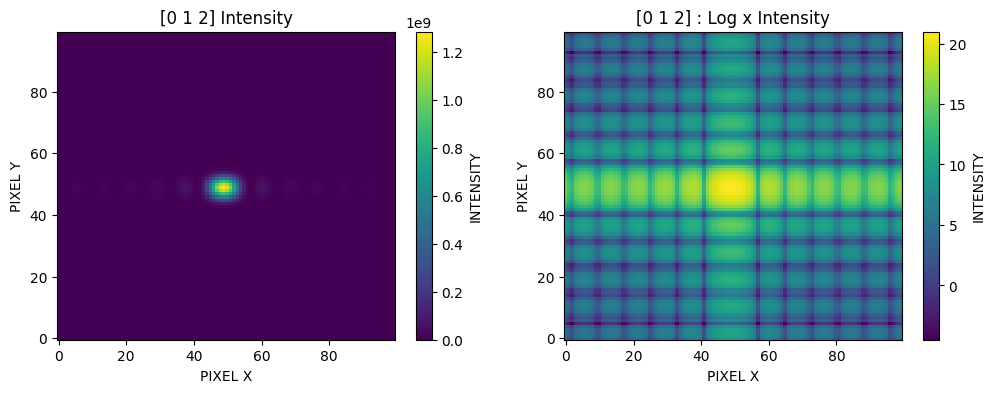

In [ ]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.pcolor(range(II.shape[0]), range(II.shape[1]), II.T)
plt.title(f'{hkl} Intensity')
plt.colorbar(label='INTENSITY')
plt.xlabel("PIXEL X")
plt.ylabel("PIXEL Y")

plt.subplot(1, 2, 2)
plt.pcolor(range(II.shape[0]), range(II.shape[1]), np.log(II.T))
plt.title(f'{hkl} : Log x Intensity')
plt.colorbar(label='INTENSITY')
plt.xlabel("PIXEL X")
plt.ylabel("PIXEL Y")

#### log plot

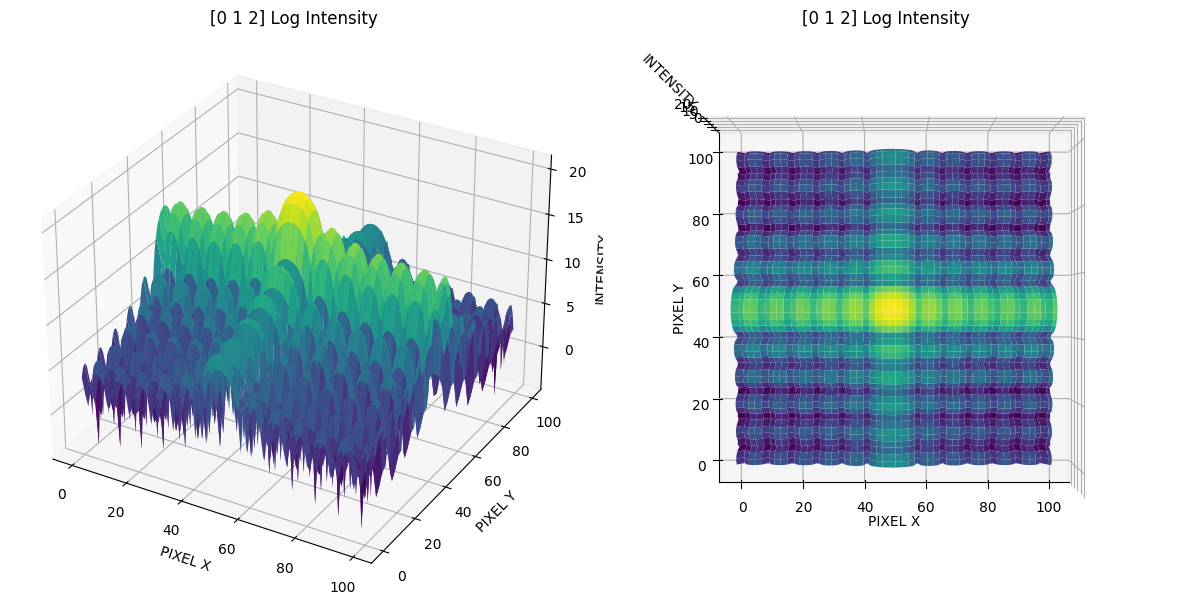

In [ ]:
fig = plt.figure(figsize=(12, 6))

#
ax = fig.add_subplot(121, projection='3d')
surf1 = ax.plot_surface(*np.meshgrid(range(II.shape[0]), range(II.shape[1])), np.log(II.T), cmap='viridis')
ax.set_xlabel('PIXEL X')
ax.set_ylabel('PIXEL Y')
ax.set_zlabel('INTENSITY')
plt.title(f'{hkl} Log Intensity')

#
ax = fig.add_subplot(122, projection='3d')
surf2 = ax.plot_surface(*np.meshgrid(range(II.shape[0]), range(II.shape[1])), np.log(II.T), cmap='viridis')
ax.view_init(elev=90, azim=-90)
ax.set_xlabel('PIXEL X')
ax.set_ylabel('PIXEL Y')
ax.set_zlabel('INTENSITY')
plt.title(f'{hkl} Log Intensity')

plt.tight_layout()
plt.show()

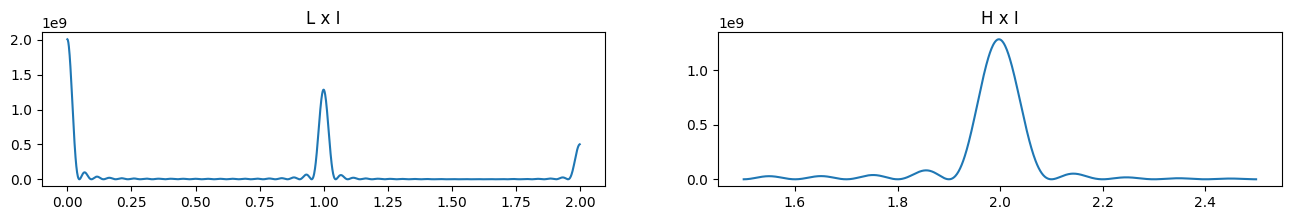

In [ ]:
LHPlot(STO, NNO)

## Alignment method
- 이미지 처리 with I[x, y]
- 피크를 기준으로 Align

center index : (49, 49)


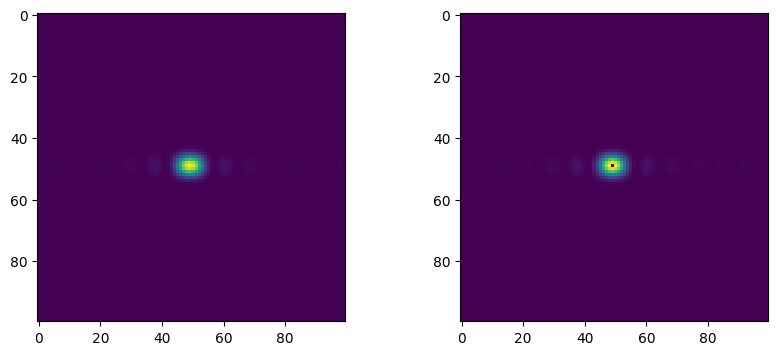

In [ ]:
# 기본적으로 다룰 이미지
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.imshow(II.T)
plt.subplot(1,2,2)
peakidx = np.unravel_index(np.argmax(II), II.shape)
print(f'center index : {peakidx}')
IC = II
IC[peakidx] = 0
plt.imshow(IC.T)

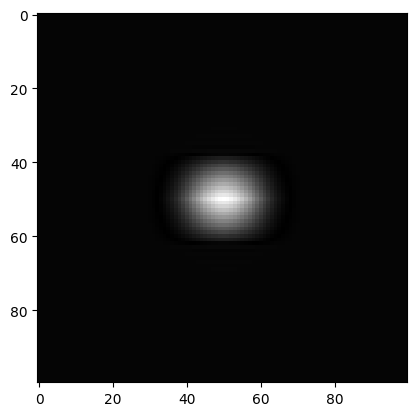

In [ ]:
# 2D image
image = II

# Compute the Fourier transform of the image
fourier_transform = np.fft.fft2(image)

# Shift the zero frequency component to the center of the spectrum
shifted_fourier_transform = np.fft.fftshift(fourier_transform)

# Calculate the magnitude of the Fourier transform
magnitude_spectrum = np.abs(shifted_fourier_transform)

# Display the magnitude spectrum
plt.imshow(magnitude_spectrum, cmap='gray')
plt.show()
